## Imports

Import the necessary library.

In [1]:
# ! pip install eli5

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
import bs4 as bs
import urllib.request
import warnings
import eli5
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Read Data

Reading the data for all the players. The data is read in Dataframes. 

In [3]:
player15_df = pd.read_csv('./data/players_15.csv')
player16_df = pd.read_csv('./data/players_16.csv')
player17_df = pd.read_csv('./data/players_17.csv')
player18_df = pd.read_csv('./data/players_18.csv')
player19_df = pd.read_csv('./data/players_19.csv')
player20_df = pd.read_csv('./data/players_20.csv')

## Data Cleanup

The purpose of the cells below is to make sure that we drop the columns that have been identified as not to be used.

In addition to the columns indicated in the statement, the team also feels that the clubs staff capabilities do not depend on other attributes like:
1. Player Height
1. Player Weight
1. Player Nationality

So these columns have been also identified as to be dropped.

In [4]:
def clean_player_df(player_df):
    '''
    Function below takes the Dataframe and drops the columns which are specified in the list above.
    '''
    return player_df.drop(columns_to_drop, axis=1)

Cleaning up all the dataframes to remove the columns identified.

## Data Analysis

For the purpose of Data Analysis, identifying columns which are numerical would simplify the quantitative analysis of the stafs capabilities. In order to identify those columns and run some preliminary analysis like min values max values, identifying the columns which are numeric.

### Step 1: Identify Numerical Columns

#### Inference from the step:
The list above indicates that there are about 24 columns which are numerical and can be leveraged for the sake of quantitative analysis. 
However further investigation of these numerical columns indicate that some of these columns could be added to the cleanup of columns as they would not really reflect the staffs capabilities to promote talent.

#### Inference Action:
Add the columns to the list of columns to be cleaned up and remove the columns.

Columns identified:
1. value_eur
1. release_clause_eur
1. team_jersey_number
1. contract_valid_until
1. nation_jersey_number

In [5]:
columns_to_drop = ["sofifa_id", "player_url", "long_name", "wage_eur", "real_face", "height_cm", "weight_kg", "nationality", 
                    "value_eur", "release_clause_eur", "team_jersey_number", "contract_valid_until","nation_jersey_number"]

In [6]:
# Further cleanup
player15_cleaned_df = clean_player_df(player15_df)
player16_cleaned_df = clean_player_df(player16_df)
player17_cleaned_df = clean_player_df(player17_df)
player18_cleaned_df = clean_player_df(player18_df)
player19_cleaned_df = clean_player_df(player19_df)
player20_cleaned_df = clean_player_df(player20_df)

In [7]:
player15_cleaned_df.head()

,short_name,age,dob,club,overall,potential,player_positions,preferred_foot,international_reputation,weak_foot,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,L. Messi,27,1987-06-24,FC Barcelona,93,95,CF,Left,5,3,...,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3
1,Cristiano Ronaldo,29,1985-02-05,Real Madrid,92,92,"LW, LM",Right,5,4,...,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3
2,A. Robben,30,1984-01-23,FC Bayern München,90,90,"RM, LM, RW",Left,5,2,...,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3
3,Z. Ibrahimović,32,1981-10-03,Paris Saint-Germain,90,90,ST,Right,5,4,...,61+3,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3
4,M. Neuer,28,1986-03-27,FC Bayern München,90,90,GK,Right,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Analyze the Numerical Columns

In order to check the quality of data available in those numerical columns, analyzing a couple of years to see the type and quality of data. 

#### Inferences:
1. The Describe on the multiple years does indicate that the mental_composure is not a column that we can rely on as the values are not captured in the earlier years and further investigation indicated that the data has a format which is a split value (e.g. and hence can be excluded 90+3)
1. International reputation is also a Categorical variable with values 1 to 5.
1. Weak Foot is a categorical value too with values 1 to 5.
1. Numerical columns 'gk_speed', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_diving' have very few values. On inspecting the players associated with those values, it was identified that these are goal keepers and attributes for goal keepers. As the question is about effectiveness of the entire staff, the approach was to drop these columns as well both for lack of data and to avoid focus on skill development for goal keepers.

#### Inference Action
1. Remove the mentality_composure value from the columns. 
2. From domain knowledge perspective, weak foot can be eliminated as other factors would reflect if the staff has improved the weak foot score of the individual.
3. International reputation is also being dropped because we are not measuring PR teams capabilities but the teams staff.
~~
4. Remove the gk_* values from the columns list.  
5. Also as the Goal Keepers are missing the information of other attributes, we might not be able to get metrics on the staffs work on the goal keepers. 
~~

In [8]:
columns_to_drop = ["player_url", "long_name", "wage_eur", "real_face", "height_cm", "weight_kg", "nationality", 
                    "value_eur", "release_clause_eur", "team_jersey_number", "contract_valid_until","nation_jersey_number",
                      "mentality_composure", "weak_foot", "international_reputation"]

In [9]:
# Reloading the data so that we can reclean
player15_df = pd.read_csv('./data/players_15.csv')
player16_df = pd.read_csv('./data/players_16.csv')
player17_df = pd.read_csv('./data/players_17.csv')
player18_df = pd.read_csv('./data/players_18.csv')
player19_df = pd.read_csv('./data/players_19.csv')
player20_df = pd.read_csv('./data/players_20.csv')

In [10]:
# Further cleanup
player15_cleaned_df = clean_player_df(player15_df)
player16_cleaned_df = clean_player_df(player16_df)
player17_cleaned_df = clean_player_df(player17_df)
player18_cleaned_df = clean_player_df(player18_df)
player19_cleaned_df = clean_player_df(player19_df)
player20_cleaned_df = clean_player_df(player20_df)

### Skills Columns

The skills columns in the dataframe indicate the different skills with a numerical value for the Skills. The team thinks that the skills are an important part of the development of every player. The player skills once improved will contribute to the overall improvement of the player and hence its overall rating. 

#### Observations:
1. Non Numeric columns: 
The columns for skills are multiple and are non numeric. Infact the columns have values with + and - signs indicating that the columns have data which indicates positive and negative traits.

#### Observation Action:

1. The decision is to exclude the columns for the first set of determination and keep only the numeric columns in the list. 
2. Build a data frame for every year with only these numeric values in addition to columns which identify the player like name, club.


In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_column_list = list(player15_cleaned_df.select_dtypes(include=numerics).columns)
print (pd.DataFrame(numeric_column_list))

                 0
0        sofifa_id
1              age
2          overall
3        potential
4      skill_moves
5             pace
6         shooting
7          passing
8        dribbling
9        defending
10          physic
11       gk_diving
12     gk_handling
13      gk_kicking
14     gk_reflexes
15        gk_speed
16  gk_positioning


#### Numerical Only Dataset

Creating a new Dataset with only numerical columns:
0          age
1      overall
2    potential
3  skill_moves
4         pace
5     shooting
6      passing
7    dribbling
8    defending
9       physic
10 short_name
11 club


In [12]:
# player_trait_columns = ["overall", "pace" "shooting","passing","dribbling" "defending"]

player_numeric_identification_columns = ['short_name', "club"] +  numeric_column_list
print (player_numeric_identification_columns)


['short_name', 'club', 'sofifa_id', 'age', 'overall', 'potential', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning']


In [13]:
player15_numeric_cleaned_df =  player15_cleaned_df[player_numeric_identification_columns]
player16_numeric_cleaned_df =  player16_cleaned_df[player_numeric_identification_columns]
player17_numeric_cleaned_df =  player17_cleaned_df[player_numeric_identification_columns]
player18_numeric_cleaned_df =  player18_cleaned_df[player_numeric_identification_columns]
player19_numeric_cleaned_df =  player19_cleaned_df[player_numeric_identification_columns]
player20_numeric_cleaned_df =  player20_cleaned_df[player_numeric_identification_columns]
numeric_column_list.remove("sofifa_id")


### Year Over Year Comparison

#### Approach
Since the purpose of the exercise is to identify the effectiveness of the staff, the approach is to identify the score differences of the players year over year. 

We are going to join data year over year and see the score differences. The approach is to create a dataframe that would have the name of the player the club and the difference in the rating of the numeric column for the player.

#### Decisions:
1. Initially the team considered only players who stayed at the club to get a guage of the players skill. However given that not many players were staying at the club, the decision was to not to enforce the stay at club metric. The credit for the increase is being assigned to the club in the earlier year.
1. The score difference will be calculated for every numeric parameter including the values which are categorical.

In [14]:
# Define a year over year dataframe in which the values will be stored
year_over_year_df = pd.DataFrame()
all_years_df = pd.DataFrame()
# year_over_year_df = player15_numeric_cleaned_df["short_name"]
# display(year_over_year_df)

In [15]:
def create_year_over_year_df(year1_df, year2_df, year):
    year1_year2_joined_df = year1_df.merge(year2_df, on="sofifa_id", suffixes=('_1', '_2'))
    year_over_year_df["short_name"] = year1_year2_joined_df["short_name_1"]
    year_over_year_df["club"] = year1_year2_joined_df["club_1"]
    year_over_year_df["age"] = year1_year2_joined_df["age_1"]    
    year_over_year_df["year_over_year"] = year
    for column in numeric_column_list:
        year_over_year_df[f"diff_{column}"] = year1_year2_joined_df[f"{column}_2"] - year1_year2_joined_df[f"{column}_1"]
        year_over_year_df[column] = year1_year2_joined_df[[f"{column}_1"]]         
    return year_over_year_df
        
all_years_df = all_years_df.append(create_year_over_year_df(player15_numeric_cleaned_df, player16_numeric_cleaned_df, 2016))
all_years_df = all_years_df.append(create_year_over_year_df(player16_numeric_cleaned_df, player17_numeric_cleaned_df, 2017)) 
all_years_df = all_years_df.append(create_year_over_year_df(player17_numeric_cleaned_df, player18_numeric_cleaned_df, 2018))
all_years_df = all_years_df.append(create_year_over_year_df(player18_numeric_cleaned_df, player19_numeric_cleaned_df, 2019)) 
all_years_df = all_years_df.append(create_year_over_year_df(player19_numeric_cleaned_df, player20_numeric_cleaned_df, 2020)) 



In [16]:
all_years_df.shape

(53440, 35)

In [17]:
all_years_df.head()
numeric_column_list = list(player15_cleaned_df.select_dtypes(include=numerics).columns)
for column in numeric_column_list: 
    if (column != 'sofifa_id'):
        all_years_df[f"diff_{column}"].fillna(0) 

### Score Difference Matrix

The year over year dataframe has all the score changes for the Club for every individual player that has played for the club.

#### Approach 1
Find the number of players who have a positive change for every metric. This would mean that we create a histogram and find how many players have a positive change. We are going to only count players who have atleast one standard deviation change of positive change in rating for every metric. That will give us indication of how important is this metric in staffs contribution.
##### Decision"
Instead of only using the Players with positive score we decided to use both negative and positive scores so the clubs which are performing bad could be penalized.

#### Approach 2
For every club find the average change in ratings for each of the metrics and then order the clubs to identify which clubs have maximum change and order those clubs. This will ensure that we not only count players which are improving but also players which are losing points.
Plot the top 10 clubs that have shown the most change.

#### Approach 3
Define a Linear Regression model to determine what should be the change in the overall rating for a player at an age.

Find the change in the Players metrics. Based upon the metrics find the overall score change that is desired based upon the individual factors using a Linear Regression model. 



#### Approach 2

In [18]:
all_years_df.head()

,short_name,club,age,year_over_year,diff_age,diff_overall,overall,diff_potential,potential,diff_skill_moves,...,diff_gk_handling,gk_handling,diff_gk_kicking,gk_kicking,diff_gk_reflexes,gk_reflexes,diff_gk_speed,gk_speed,diff_gk_positioning,gk_positioning
0,L. Messi,FC Barcelona,27,2016,1,1,93,0,95,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cristiano Ronaldo,Real Madrid,29,2016,1,1,92,1,92,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A. Robben,FC Bayern München,30,2016,1,0,90,0,90,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Z. Ibrahimović,Paris Saint-Germain,32,2016,1,-1,90,-1,90,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M. Neuer,FC Bayern München,28,2016,1,0,90,0,90,0,...,2.0,85.0,-1.0,92.0,0.0,86.0,0.0,60.0,0.0,90.0


#### Observation:

From the graphs above we observe:
1. Players of higher ages tend to show less changes in all the metrics. Infact playersa above the age between 30 and 35 tend to show lesser changes in the skill area improvements. 
2. Younger players do tend to show higher changes in the skill profile values.
3. Certain higher values for differences might skew the data and might have to be removed.

#### Actions:
1. Age definitely plays a role in the calculation of the score changes and hence we are going to calculate the average on every age.
1. Average the score changes for a club at every age and identify the clubs which are performing better. 

In [19]:
all_years_df = all_years_df.fillna(0)

In [20]:
all_years_df.head()

,short_name,club,age,year_over_year,diff_age,diff_overall,overall,diff_potential,potential,diff_skill_moves,...,diff_gk_handling,gk_handling,diff_gk_kicking,gk_kicking,diff_gk_reflexes,gk_reflexes,diff_gk_speed,gk_speed,diff_gk_positioning,gk_positioning
0,L. Messi,FC Barcelona,27,2016,1,1,93,0,95,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cristiano Ronaldo,Real Madrid,29,2016,1,1,92,1,92,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A. Robben,FC Bayern München,30,2016,1,0,90,0,90,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Z. Ibrahimović,Paris Saint-Germain,32,2016,1,-1,90,-1,90,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M. Neuer,FC Bayern München,28,2016,1,0,90,0,90,0,...,2.0,85.0,-1.0,92.0,0.0,86.0,0.0,60.0,0.0,90.0


In [21]:
year_over_year_metrics_averaged = all_years_df
year_over_year_metrics_averaged = year_over_year_metrics_averaged.drop(["short_name"], axis=1)
year_over_year_metrics_averaged = year_over_year_metrics_averaged.groupby(["club", "year_over_year"]).mean().reset_index()
year_over_year_metrics_averaged = year_over_year_metrics_averaged.dropna()

display (year_over_year_metrics_averaged.head())

,club,year_over_year,age,diff_age,diff_overall,overall,diff_potential,potential,diff_skill_moves,skill_moves,...,diff_gk_handling,gk_handling,diff_gk_kicking,gk_kicking,diff_gk_reflexes,gk_reflexes,diff_gk_speed,gk_speed,diff_gk_positioning,gk_positioning
0,SSV Jahn Regensburg,2019,25.450000,1.0,1.900000,65.600000,1.000000,69.750000,0.050000,2.300000,...,0.100000,6.400000,0.100000,6.350000,0.050000,7.250000,0.0,3.800000,0.550000,5.800000
1,SSV Jahn Regensburg,2020,26.217391,1.0,0.478261,66.913043,-0.086957,69.826087,0.043478,2.304348,...,0.130435,5.652174,0.000000,5.608696,0.000000,6.347826,0.0,3.304348,0.086957,5.521739
2,1. FC Heidenheim 1846,2016,24.500000,1.0,3.812500,62.750000,3.187500,66.500000,0.000000,2.250000,...,0.250000,3.937500,0.187500,3.750000,0.375000,4.125000,0.0,2.937500,0.250000,4.000000
3,1. FC Heidenheim 1846,2017,24.238095,1.0,2.190476,64.761905,0.333333,70.095238,0.000000,2.285714,...,0.047619,6.142857,0.000000,5.761905,0.000000,6.809524,0.0,4.476190,0.000000,6.428571
4,1. FC Heidenheim 1846,2018,23.909091,1.0,1.363636,66.181818,0.409091,71.318182,0.000000,2.363636,...,0.045455,5.681818,0.409091,5.181818,0.272727,6.045455,0.0,4.045455,0.181818,5.772727


In [22]:
# Finding Clubs which have done better in all age group
sortable_columns = []
for column in all_years_df.columns:
    if ("diff_" in column and column != "diff_age"):
        sortable_columns.append(column)
best_clubs_any_year = year_over_year_metrics_averaged.sort_values(by=sortable_columns, ascending = False).head(10)
display (best_clubs_any_year)

,club,year_over_year,age,diff_age,diff_overall,overall,diff_potential,potential,diff_skill_moves,skill_moves,...,diff_gk_handling,gk_handling,diff_gk_kicking,gk_kicking,diff_gk_reflexes,gk_reflexes,diff_gk_speed,gk_speed,diff_gk_positioning,gk_positioning
2726,Stade Lavallois Mayenne FC,2018,21.000000,1.0000,8.000000,60.000000,7.000000,67.0000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.000000,0.000000
2536,Sandefjord Fotball,2017,21.000000,1.0000,8.000000,63.000000,6.000000,71.0000,0.000000,1.000000,...,5.000000,63.000000,0.000000,68.000000,11.0000,65.0000,-1.0,44.000000,3.000000,61.000000
1037,FC Anzhi Makhachkala,2019,22.000000,1.0000,8.000000,63.000000,5.000000,72.0000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.000000,0.000000
1308,GD Chaves,2018,23.000000,1.0000,7.000000,70.000000,6.500000,74.5000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.000000,0.000000
2933,Uruguay,2017,26.000000,1.0000,7.000000,69.000000,6.000000,72.0000,0.000000,1.000000,...,5.000000,70.000000,-1.000000,73.000000,10.0000,71.0000,0.0,44.000000,-2.000000,73.000000
1420,Hajer,2016,24.375000,0.9375,6.062500,53.062500,6.875000,56.6875,0.187500,2.125000,...,0.062500,3.687500,0.062500,3.750000,0.5625,3.4375,0.0,2.812500,0.062500,3.437500
2685,Sporting Club de Bastia,2017,20.000000,1.0000,6.000000,62.000000,7.000000,72.0000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.000000,0.000000
509,Busan IPark,2016,21.000000,1.0000,6.000000,58.000000,5.000000,65.0000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0,0.000000,0.000000,0.000000
844,Côte d'Ivoire,2016,25.000000,1.0000,6.000000,57.000000,4.000000,62.0000,0.000000,1.000000,...,9.000000,52.000000,4.000000,66.000000,8.0000,54.0000,0.0,41.000000,4.000000,59.000000
991,Envigado FC,2016,23.315789,1.0000,5.894737,59.578947,5.368421,66.0000,0.157895,2.052632,...,0.421053,6.368421,0.631579,5.789474,0.0000,7.0000,0.0,4.263158,0.789474,6.210526


## Test and Train Set

The problem states that we are using the data from the Division 1 European League. In order to make that happen for the data that we have cleaned up, we are going to separate the data for the clubs into Train set belonging to the players from the league.

#### Steps:
1. Investigation of the dataset has indicated that the League information is not in the data file and needs to be fetched from the web using the scraping approach.
2. Once the scraping pulls data the data is going to be appended to the club score changes dataframe. 

#### Model Options
1. Linear Model using fixed values based upon the score changes.
2. Linear Model but instead of using fixed values use the coefficients of the linear equation that generates the overall score and then assign the score based upon the coefficient values.


#### Approach:
1. Read the Club Data and the Leagues data files
2. Match the club and the leagues in which the clubs play
3. Create a test data set and a train dataset by excluding the the clubs that are associated with the Leagues marked as Test data.


### Web Scraping

The leagues and teams dataset does not have any correlation with the clubs that play in a league and hence we need to scrape that data from the sofifa site.
The url field in the dataset can be used to make a web request and then download the data.

In [23]:
import requests
def parseTeamNameFromUrl(team_url_id):

    source = requests.get(f"https://sofifa.com/team/{team_url_id}")
    soup = bs.BeautifulSoup(source.content)
    team_info_divs = soup.findAll("div", {"class": "info"})
    team_name = 'not found'
    for div in team_info_divs:
        team_name = div.find("h1").text 
    print (team_name)
    return team_name

In [24]:
parseTeamNameFromUrl(9)

Liverpool


'Liverpool'

#### Web Scraping End

Once the web scraping is done we do not intend to save the file and no need to keep running the scraping every execution. This is the lambda based approach to make a call to every row and pull the data. this is not done everytime and I have pulled that data down to my machine.

In [25]:
leagues_with_club_df = pd.read_csv('./data/teams_leagues_clubs.csv')
display(leagues_with_club_df)

,url,league_name,club
0,241,Spain Primera Division,FC Barcelona
1,11,English Premier League,Manchester United
2,5,English Premier League,Chelsea
3,243,Spain Primera Division,Real Madrid
4,1,English Premier League,Arsenal
...,...,...,...
1075,326,Turkish Süper Lig,Fenerbahçe SK
1076,190,Italian Serie A,Brescia
1077,448,Spain Primera Division,Athletic Club de Bilbao
1078,8,English League Championship,Leeds United


In [26]:
# leagues_df["club"] = leagues_df.apply(lambda x: parseTeamNameFromUrl(x['url']),axis=1)


In [27]:
# display(leagues_df)
# leagues_df.to_csv('./data/teams_leagues_clubs.csv', index=False)

Add the league information into the dataframe to be able to sort the data.

In [28]:
year_over_year_metrics_averaged_with_leagues = year_over_year_metrics_averaged.merge(leagues_with_club_df, on="club", suffixes=('_1', '_2'))
display(year_over_year_metrics_averaged_with_leagues)

,club,year_over_year,age,diff_age,diff_overall,overall,diff_potential,potential,diff_skill_moves,skill_moves,...,diff_gk_kicking,gk_kicking,diff_gk_reflexes,gk_reflexes,diff_gk_speed,gk_speed,diff_gk_positioning,gk_positioning,url,league_name
0,1. FC Heidenheim 1846,2016,24.500000,1.0,3.812500,62.750000,3.187500,66.500000,0.000000,2.250000,...,0.187500,3.750000,0.375000,4.125000,0.0,2.937500,0.250000,4.000000,111235,German 2. Bundesliga
1,1. FC Heidenheim 1846,2017,24.238095,1.0,2.190476,64.761905,0.333333,70.095238,0.000000,2.285714,...,0.000000,5.761905,0.000000,6.809524,0.0,4.476190,0.000000,6.428571,111235,German 2. Bundesliga
2,1. FC Heidenheim 1846,2018,23.909091,1.0,1.363636,66.181818,0.409091,71.318182,0.000000,2.363636,...,0.409091,5.181818,0.272727,6.045455,0.0,4.045455,0.181818,5.772727,111235,German 2. Bundesliga
3,1. FC Heidenheim 1846,2019,24.913043,1.0,0.695652,67.260870,-0.565217,71.391304,-0.043478,2.391304,...,0.000000,5.217391,0.043478,6.173913,0.0,4.000000,0.086957,5.869565,111235,German 2. Bundesliga
4,1. FC Heidenheim 1846,2020,25.217391,1.0,1.434783,67.347826,0.130435,71.478261,0.000000,2.347826,...,0.000000,5.217391,0.000000,6.217391,0.0,4.000000,0.043478,5.956522,111235,German 2. Bundesliga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,Örebro SK,2019,26.750000,1.0,1.250000,65.000000,0.833333,67.166667,0.083333,2.333333,...,0.083333,5.083333,0.000000,5.916667,0.0,2.500000,0.166667,5.416667,705,Swedish Allsvenskan
3391,Örebro SK,2020,28.100000,1.0,0.200000,64.800000,-0.400000,66.900000,0.000000,2.100000,...,0.200000,6.200000,-0.200000,7.100000,0.0,3.000000,0.100000,6.700000,705,Swedish Allsvenskan
3392,Östersunds FK,2018,24.266667,1.0,2.600000,63.600000,1.266667,68.200000,0.133333,2.133333,...,0.000000,5.000000,0.266667,4.333333,0.0,1.466667,0.000000,3.666667,113173,Swedish Allsvenskan
3393,Östersunds FK,2019,25.055556,1.0,0.888889,65.111111,0.000000,68.777778,0.055556,2.222222,...,0.166667,7.277778,0.166667,7.166667,0.0,2.777778,0.000000,6.388889,113173,Swedish Allsvenskan


### Helper Code

In [29]:
# Since we are splitting based upon data points and not a percentage, this method would get the x and y train sets
def train_test_split_custom():
    club_test_set = year_over_year_metrics_averaged_with_leagues[year_over_year_metrics_averaged_with_leagues['league_name'].isin(["English Premier League ", "German 1. Bundesliga ", "French Ligue 1 ", "Spain Primera Division ", "Italian Serie A "])]

    club_train_set = year_over_year_metrics_averaged_with_leagues[~year_over_year_metrics_averaged_with_leagues['league_name'].isin(["Division 1 European League "])]

#     x_train = club_train_set.drop(["club","year_over_year","age","diff_age","diff_overall","league_name"], axis=1)
#     y_train = club_train_set["diff_overall"]

#     x_test = club_test_set.drop(["club","year_over_year","age","diff_age","diff_overall","league_name"], axis=1)
#     y_test = club_test_set["diff_overall"]
    
    x_train = club_train_set.drop(["club","year_over_year","diff_age","diff_overall","league_name"], axis=1)
    y_train = club_train_set["diff_overall"]

    x_test = club_test_set.drop(["club","year_over_year","diff_age","diff_overall","league_name"], axis=1)
    y_test = club_test_set["diff_overall"]    
    
    return club_train_set, club_test_set, x_train, y_train, x_test, y_test

In [30]:
def generate_scored_df( train_df, test_df):
    
    club_test_set_results = test_df.copy()
    club_test_set_results["score"] = club_test_set_results["diff_overall"] - club_test_set_results["predicted"] 
    club_test_set_results = club_test_set_results.drop(["year_over_year", "diff_age"], axis=1)
    club_test_set_results = club_test_set_results.groupby(["club"]).mean().reset_index()
    cols_to_norm = ['score']
    club_test_set_results[cols_to_norm] = club_test_set_results[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    club_test_set_results[cols_to_norm] = club_test_set_results[cols_to_norm] * 100
    
    club_train_set_results = train_df.copy()
    club_train_set_results["score"] = club_train_set_results["diff_overall"] - club_train_set_results["predicted"] 
    club_train_set_results = club_train_set_results.drop(["year_over_year", "diff_age"], axis=1)
    club_train_set_results = club_train_set_results.groupby(["club"]).mean().reset_index()
    cols_to_norm = ['score']
    club_train_set_results[cols_to_norm] = club_train_set_results[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    club_train_set_results[cols_to_norm] = club_train_set_results[cols_to_norm] * 100
    
    return club_train_set_results, club_test_set_results

### Model Analysis and Visualization Helpers

In [31]:
def displayModelTestScoreAgeScatter(club_test_set_model):
    plt.scatter(club_test_set_model["age"], club_test_set_model["score"])
    plt.xlabel("Age")
    plt.ylabel("Score")
    plt.title("Club Scores at different Ages")
    plt.show()

def displayModelTestScoreClubHistogram(club_test_set_model):
    plt.hist(club_test_set_model[club_test_set_model["score"] > 20]["score"], bins=20)
    plt.xlabel("Score")
    plt.ylabel("Number of Clubs")
    plt.title("Histogram showing number of clubs with Score greater than 20")
    plt.show()
    
def displayModelTestScoreClubHistogramByLeague(club_test_set_model):
    league_names = club_test_set_model.league_name.unique()
    league_scores = []
    for league_name in league_names:
        league_scores.append(club_test_set_model[club_test_set_model["league_name"] == league_name]["score"].values)

    plt.figure(figsize=(20,10))
    plt.hist(league_scores, bins = 10, histtype='bar', label=league_names)
    plt.xlabel("Score")
    plt.ylabel("Number of Clubs")

    plt.legend()
    plt.show()

def displayTop10ClubsForEachAge(club_test_set_model):

    fig, axs = plt.subplots(5,3,figsize=(32,16))
    collabel=("Club", "Score")
    i = 0
    j = 0
    for i in [0,1,2,3,4]: 
        for j in [0,1,2]:
            axs[i][j].axis('tight')
            axs[i][j].axis('off')
            age = i*3+j+16
            club_test_data_for_age = club_test_set_model[club_test_set_model["age"] == age].sort_values(by="score", ascending = False).head(10)
            outof = len(club_test_set_model[club_test_set_model["age"] == age])
            result = club_test_data_for_age[["club","score"]]
            result['score'] = result['score'].map('{:.4f}'.format)
            axs[i][j].table(cellText=result.values, colLabels=collabel, loc='center',colWidths=[0.3 for x in collabel])
            axs[i][j].set_title(f"Clubs identified as top {len(club_test_data_for_age)} out of {outof} for Age - {age} ")

    plt.show()
    
#     # Finding the Clubs that performed best overall at all ages
#     club_test_set_model = club_test_set_model.drop_duplicates()
#     all_ages_club_df = pd.DataFrame()
#     for age in range(16, 41):
#         club_test_data_for_age = club_test_set_model[club_test_set_model["age"] == age].sort_values(by="score", ascending = False).head(10)
#         all_ages_club_df=all_ages_club_df.append(club_test_set_model, ignore_index=True)

#     all_ages_club_mean_scores_df = all_ages_club_df.groupby(by=["club"]).mean()[["score"]]
#     result_df = all_ages_club_mean_scores_df.sort_values(by="score", ascending=False)
#     print ("Top 10 Clubs")
#     display(result_df.head(10))    
    
def displayBestClubsOverAllAges(club_test_set_model):
    club_test_set_model = club_test_set_model.drop_duplicates()
    all_ages_club_mean_scores_df = club_test_set_model.groupby(by=["club"]).mean()[["score"]]
    result_df = all_ages_club_mean_scores_df.sort_values(by="score", ascending=False)
    print ("Top 10 Clubs")
    display(result_df.head(10))
    
def displayBestClubs(club_test_set_model):
    # Finding the Clubs that performed best overall at all ages
    club_test_set_model = club_test_set_model.drop_duplicates()
    all_ages_club_mean_scores_df = club_test_set_model.groupby(by=["club"]).mean()[["score"]]
    result_df = all_ages_club_mean_scores_df.sort_values(by="score", ascending=False)
    print ("Top 10 Clubs")
    display(result_df.head(10))

### Scoring Model

The Scoring Approach is to train a model on the difference of the overall score of the club for all the parameters. Once the model is trained predict the overall score improvements anticipated from the other factors for the club. If the overall predicted score is greater then give the team a positive score else give the team a negative score. Normalize the scores on a scale of 100. In order to predict the scores we have used 3 models - Linear, Linear with Ridge and Random Forests

#### Linear Regression Model

In [32]:
club_train_set, club_test_set, x_train, y_train, x_test, y_test = train_test_split_custom()

linreg = LinearRegression()
linreg.fit(x_train, y_train)

y_train_pred = linreg.predict(x_train)
y_test_pred = linreg.predict(x_test)

# predicted_test_score_improvement = year_over_year_metrics_averaged[["club","diff_overall"]]
club_train_set["predicted"] = y_train_pred
club_test_set["predicted"] = y_test_pred

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print ("Basic Linear Regression\n")
print (f"Train MSE basic Linear Regression: {mse_train:.4f}")
print (f"Test MSE basic Linear Regression: {mse_test:.4f}")

r2 = r2_score(y_test, y_test_pred)
print (f"R2 values of Basic Linear Reqression: {r2}")

Basic Linear Regression

Train MSE basic Linear Regression: 0.1356
Test MSE basic Linear Regression: 0.1085
R2 values of Basic Linear Reqression: 0.8908904072302944


<ipython-input-32-ccaf16257886>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  club_test_set["predicted"] = y_test_pred


#### Linear Regression Basic Model - Score Calculation and Normalization

In [33]:
club_train_set_lin_reg_results, club_test_set_lin_reg_results = generate_scored_df(club_train_set, club_test_set)

In [34]:
displayBestClubsOverAllAges(club_test_set_lin_reg_results)

Top 10 Clubs


,score
club,
SC Paderborn 07,100.000000
FC Nantes,97.745957
SC Freiburg,92.145549
Borussia Dortmund,90.572451
Crystal Palace,84.943887
RB Leipzig,82.155268
Bournemouth,80.596605
1. FSV Mainz 05,80.067715
TSG 1899 Hoffenheim,80.066615


#### Linear Model Ridge Regularization 

In [35]:
club_train_set, club_test_set, x_train, y_train, x_test, y_test = train_test_split_custom()

maxdeg = 2
x_poly_train = PolynomialFeatures(maxdeg).fit_transform(x_train)
x_poly_test = PolynomialFeatures(maxdeg).fit_transform(x_test)
alpha_list = [0.001, 0.01, 0.1]
best_parameter = 0.01
# # Create two lists for training and validation error
# training_error, validation_error = [],[]
# for i in alpha_list:

#     print (i)
#     ridge_reg = Ridge(alpha=i,normalize=True)

#     #Fit on the entire data because we just want to see the trend of the coefficients

#     ridge_reg.fit(x_poly_train, y_train)
    
#     # Perform cross validation on the modified data with neg_mean_squared_error as the scoring parameter and cv=5
#     # Remember to get the train_score
#     ridge_cv = cross_validate(ridge_reg, x_poly_train, y_train, cv=5,scoring='neg_mean_squared_error',return_train_score=True)

#     # Compute the training and validation errors got after cross validation
#     mse_train = np.mean(np.abs(ridge_cv["train_score"]))
#     mse_val = np.mean(np.abs(ridge_cv["test_score"]))

#     # Append the MSEs to their respective lists 
#     training_error.append(mse_train)
#     validation_error.append(mse_val)
    
#     print(f"done {i}")
    
# # Get the best mse from the validation_error list
# best_mse  =  min(validation_error)

# # Get the best alpha value based on the best mse
# best_parameter = alpha_list[validation_error.index(best_mse)]
# print (best_parameter)


In [36]:
ridge_reg = Ridge(alpha=best_parameter,normalize=True)

#Fit on the entire data because we just want to see the trend of the coefficients

ridge_reg.fit(x_poly_train, y_train)

y_train_pred = ridge_reg.predict(x_poly_train)
y_test_pred = ridge_reg.predict(x_poly_test)

In [37]:
# predicted_test_score_improvement = year_over_year_metrics_averaged[["club","diff_overall"]]

club_train_set["predicted"] = y_train_pred
club_test_set["predicted"] = y_test_pred

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print (f"Train MSE for Ridge Model {mse_train:.4f}")
print (f"Test MSE for Ridge Model {mse_test:.4f}")

r2 = r2_score(y_test, y_test_pred)
print (f"R2 for Ridge Model: {r2:.4f}")

Train MSE for Ridge Model 0.1076
Test MSE for Ridge Model 0.0982
R2 for Ridge Model: 0.9012


<ipython-input-37-3cb8e85d9414>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  club_test_set["predicted"] = y_test_pred


#### Linear Ridge Model - Score Calculation and Normalization

In [38]:
club_train_set_ridge_reg_results, club_test_set_ridge_reg_results = generate_scored_df(club_train_set, club_test_set)

In [39]:
displayBestClubsOverAllAges(club_test_set_ridge_reg_results)

Top 10 Clubs


,score
club,
SC Paderborn 07,100.000000
Crystal Palace,92.139647
FC Nantes,88.524247
SC Freiburg,87.594342
Borussia Dortmund,86.047716
Amiens SC,81.200271
TSG 1899 Hoffenheim,80.337045
Sheffield United,79.031475
Roma,77.845912


#### Random Forest Model 

In [40]:
club_train_set, club_test_set, x_train, y_train, x_test, y_test = train_test_split_custom()

max_depth = 15
random_state = 144
random_forest = RandomForestRegressor(max_depth=max_depth, random_state=random_state, n_estimators=250, max_features = 15)

# Fit the model on the training set
random_forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, max_features=15, n_estimators=250,
                      random_state=144)

In [41]:
y_train_pred = random_forest.predict(x_train)
y_test_pred = random_forest.predict(x_test)

In [42]:
# predicted_test_score_improvement = year_over_year_metrics_averaged[["club","diff_overall"]]
club_train_set["predicted"] = y_train_pred
club_test_set["predicted"] = y_test_pred

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print (f"Train MSE for Random Forest {mse_train:.4f}")
print (f"Test MSE for Random Forest {mse_test:.4f}")

r2 = r2_score(y_test, y_test_pred)
print (f"R2 Squared value for Random Forest: {r2:.4f}")

Train MSE for Random Forest 0.0211
Test MSE for Random Forest 0.0086
R2 Squared value for Random Forest: 0.9913


<ipython-input-42-5ebf1dd433ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  club_test_set["predicted"] = y_test_pred


In [43]:
club_train_set_rf_results, club_test_set_rf_results = generate_scored_df(club_train_set, club_test_set)

##### Linear Regression Model

Using the Linear Regression Model we are going to check the effectiveness of the scores that were generated. 

The approach is to use the train set and fit the model on the training set and then compare if the test set gets values similar to our calculated values.

In [44]:
x_train = club_train_set_rf_results.drop(["club","score", "predicted"], axis=1)
y_train = club_train_set_rf_results["score"]

x_test = club_test_set_rf_results.drop(["club","score", "predicted"], axis=1)
y_test = club_test_set_rf_results["score"]

linreg = LinearRegression()
# Fitting the model on the train data and the train output.
linreg.fit(x_train, y_train)

# Checking the MSE values on the train data
y_train_pred = linreg.predict(x_train)

mse_train = mean_squared_error(y_train, y_train_pred)

# predicting the score
y_test_pred = linreg.predict(x_test)

# Determine the error.
mse_test = mean_squared_error(y_test, y_test_pred)
print (f"Train MSE for the Scores calculated via Linear Regression: {mse_train:.4f}")
print (f"Test MSE for the Scores calculated via Linear Regression: {mse_test:.4f}")

Train MSE for the Scores calculated via Linear Regression: 14.2079
Test MSE for the Scores calculated via Linear Regression: 293.8342


In [45]:
displayBestClubsOverAllAges(club_test_set_rf_results)

Top 10 Clubs


,score
club,
Amiens SC,100.000000
SC Paderborn 07,94.531505
1. FSV Mainz 05,89.507989
FC Nantes,84.055466
FC Girondins de Bordeaux,83.422974
Sheffield United,80.809517
Sampdoria,80.605457
Stade Brestois 29,80.582568
Sassuolo,79.894167


### Model Analysis

#### Model Results

We will now find the top 10 clubs performing at each age group to determine the best performance for every age.

We are going to use the scores to determine the clubs which have done.
The graphs generated are:
1. Scores vs Age which identifies what is the club distribution and the scores for clubs for Age.
3. A Table of Top 10 Clubs for each player age available in the Dataset
4. Clubs which have done better over all ages.

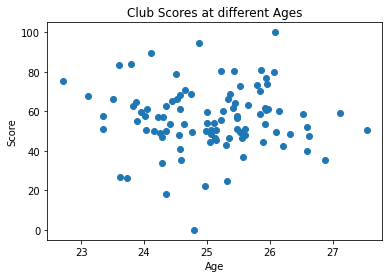

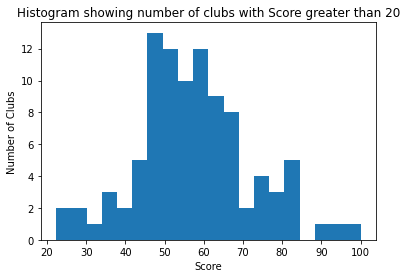

In [46]:
displayModelTestScoreAgeScatter(club_test_set_rf_results)
displayModelTestScoreClubHistogram(club_test_set_rf_results)
# displayModelTestScoreClubHistogramByLeague(club_test_set)



#### Clubs which are best for each Age

IndexError: index 0 is out of bounds for axis 0 with size 0

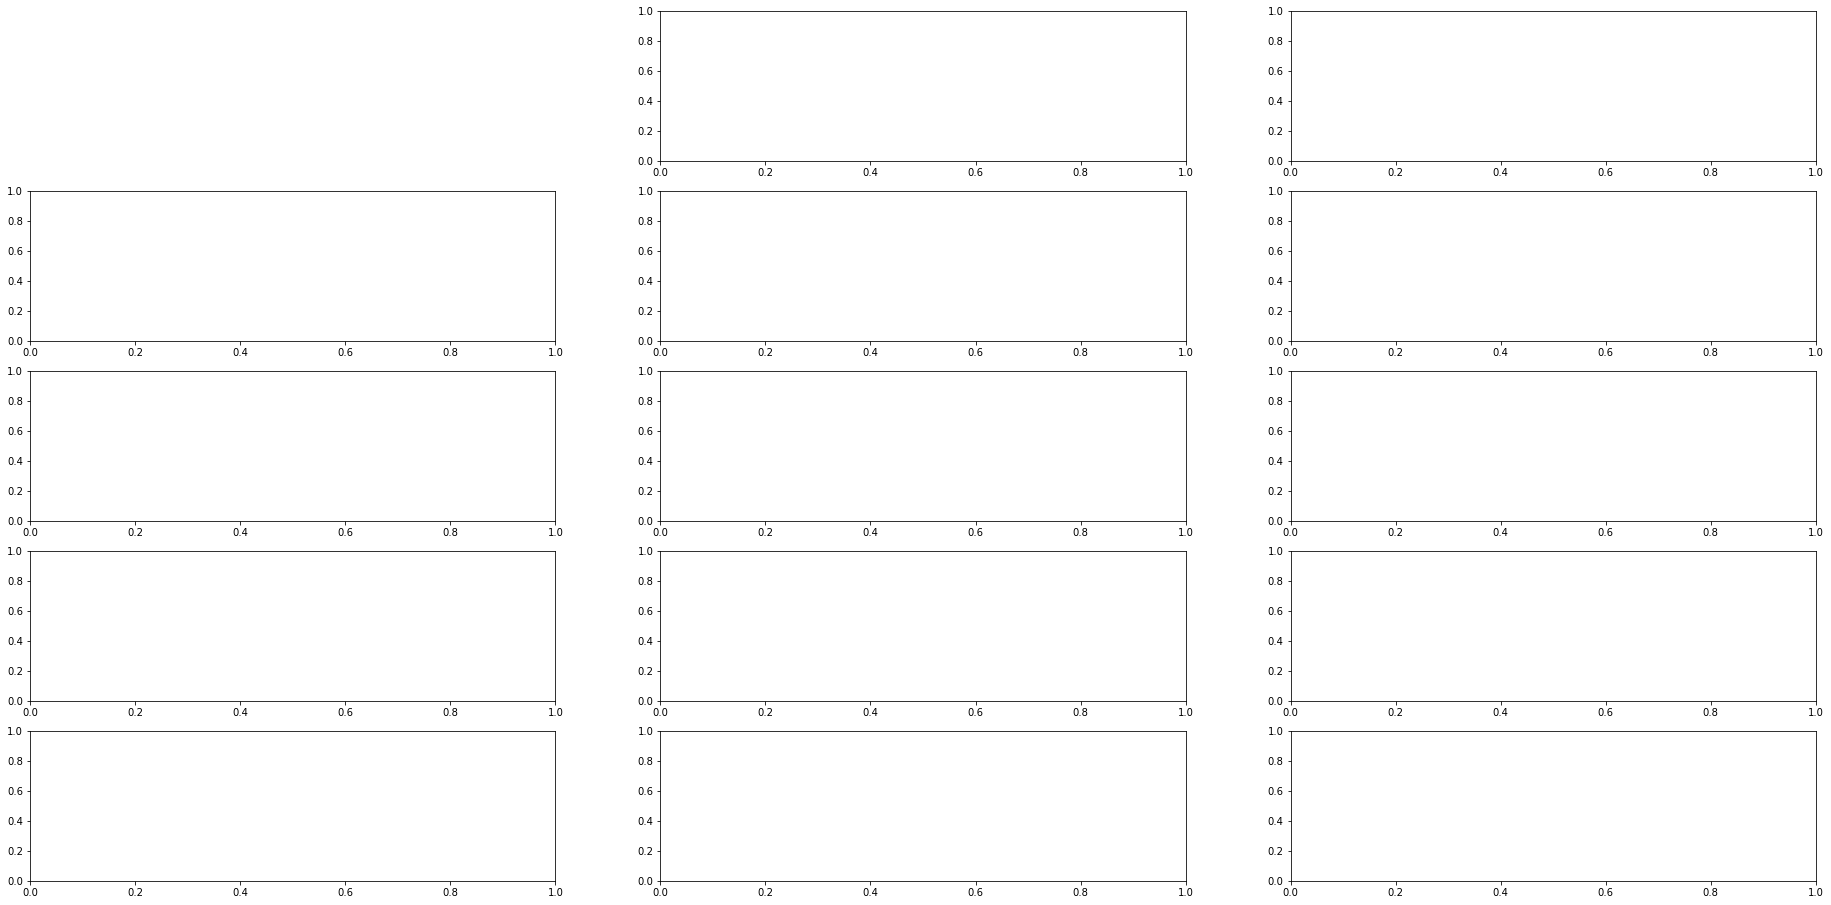

In [47]:
# displayTop10ClubsForEachAge(club_test_set_rf_results)

### Best Clubs Overall

In [48]:
displayBestClubsOverAllAges(club_test_set_rf_results)

Top 10 Clubs


,score
club,
Amiens SC,100.000000
SC Paderborn 07,94.531505
1. FSV Mainz 05,89.507989
FC Nantes,84.055466
FC Girondins de Bordeaux,83.422974
Sheffield United,80.809517
Sampdoria,80.605457
Stade Brestois 29,80.582568
Sassuolo,79.894167


## END OF SUBMISSION
---

### Potential Scoring Approach

The player overall score is an indicator of the players overall improvement of his abilities aggregated over. The approach for a Data Driven scoring model is to consider using the individual parameters contributing to the overall score values. 

Approach here is to run a learning model to determine what is the impact of the individual parameters on the overall score. The idea is to then determine how important are these parameters on the overall score. Once the impact on the overall score is identified, the next step is to then evaluate the staff on the basis of the importance for each of those factor improvements for the groups. 

An e.g. of this approach would be if dribbling and skill moves are more important then we might be able to give the support staff more credit for improving the dribbling and skill moves values over other values and then generate a score.

This approach also requires eliminating the overall score from the dataset for the score calculation. The approach is to use only the individual parameters for the determination of the effectiveness of the support staff in improving it. 

We will continue with the approach that if the support staff has improved the parameter score they would get a positive score but if they failed to improve the score then they get dinged.

#### Random Forest Model

The Random Forest approach uses Decision trees with different parameters in every iteration and helps identify importance of the parameters over multiple iterations. The approach here was to use the Random Forest to identify the parameters that are useful to determine the parameters that contribute the most to the determination of the important parameters. We used the RandomForestRegressor as overall is not a categorical but a continous value. 

The Random Forest Regressor was run for over 250 iterations and max features of 4 to ensure that the features are dropped periodically. Then using the predictors determined or picked the important_features list is prepared. 

##### Normalization of Parameters:

We observe that the important columns are being identified below as ['potential', 'dribbling', 'passing', 'shooting', 'defending', 'physic'] but the number of times those columns are identified as the primary column are different. In the next step we normalize them on a score of 0 to 1 to identify how important they are and then use the important columns to create a score for the club. 

##### Normalization of Generated Scores

The problem states that the score for the Staff should not be more than 100 so we are normalizing the scores to a max value of 100 and between 0 to 100. 

In [ ]:
club_train_set, club_test_set, x_train, y_train, x_test, y_test = train_test_split_custom()

club_train_set_for_RF = club_train_set
# x_train_set_for_RF = club_train_set_for_RF.drop(["diff_overall", "club", "league_name", "url"], axis=1)
# y_train_set_for_RF = club_train_set_for_RF["diff_overall"]

max_depth = 15
random_state = 144
random_forest = RandomForestRegressor(max_depth=max_depth, random_state=random_state, n_estimators=250, max_features = 8)

# Fit the model on the training set
random_forest.fit(x_train, y_train)


In [ ]:
top_predictors_rf = {}
for rfestimator_tree in random_forest.estimators_:
    # print (rfestimator_tree.tree_.feature)
    try:
        top_predictors_rf[rfestimator_tree.tree_.feature[0]] += 1
    except:
        top_predictors_rf[rfestimator_tree.tree_.feature[0]] = 1

print(x_train.columns)
print(top_predictors_rf)

In [ ]:
important_columns = []
for k in top_predictors_rf.keys():
    important_columns.append(x_train.columns[k])
print (important_columns)

In [ ]:
important_columns_imp = [] 
for i in top_predictors_rf.values():
    important_columns_imp.append(i)
print (important_columns_imp)

#### Normalization:

We observe that the important columns are being identified below as ['potential', 'dribbling', 'passing', 'shooting', 'defending', 'physic'] but the number of times those columns are identified as the primary column are different. In the next step we normalize them on a score of 0 to 1 to identify how important they are and then use the important columns to create a score for the club. 

In [ ]:
important_columns_norm = [float(i)/sum(important_columns_imp) for i in important_columns_imp] 
important_columns_norm

##### Scoring Approach

Instead of scoring each parameter which is positive as a fixed value, we are going to only score the important columns and also we are going to give the score a value which is product of the score change and importance normalized. 
Also we are now going to create a Train Set and Test set with the scores for the values.

In [ ]:
club_train_set_with_rf_col_score = club_train_set
club_train_set_with_rf_col_score["score"] = 0
scale = len(important_columns)
i = 0
for column in important_columns:
        club_train_set_with_rf_col_score.loc[club_train_set_with_rf_col_score[column] > 0, 'score'] += club_train_set_with_rf_col_score[column] * important_columns_norm[i]
        club_train_set_with_rf_col_score.loc[club_train_set_with_rf_col_score[column] == 0, 'score'] += 0            
        club_train_set_with_rf_col_score.loc[club_train_set_with_rf_col_score[column] < 0, 'score'] -= club_train_set_with_rf_col_score[column] * important_columns_norm[i]            
        i += 1
club_train_set_with_rf_col_score.head()
club_train_set_with_rf_col_score.shape

In [ ]:
club_test_set_with_rf_col_score = club_test_set
club_test_set_with_rf_col_score["score"] = 0
scale = len(important_columns)
for column in important_columns:
        club_test_set_with_rf_col_score.loc[club_test_set_with_rf_col_score[column] > 0, 'score'] += club_test_set_with_rf_col_score[column] * scale
        club_test_set_with_rf_col_score.loc[club_test_set_with_rf_col_score[column] == 0, 'score'] += 0            
        club_test_set_with_rf_col_score.loc[club_test_set_with_rf_col_score[column] < 0, 'score'] -= club_test_set_with_rf_col_score[column] * scale 
        scale -= 1
club_test_set_with_rf_col_score.head()
club_test_set_with_rf_col_score.shape

##### Normalization of Generated Scores
The problem states that the score for the Staff should not be more than 100 so we are normalizing the scores to a max value of 100 and between 0 to 100. The scores are normalized for both test and train sets.


In [ ]:
# club_train_set_with_rf_col_score = club_train_set_with_rf_col_score.fillna()
x_train_with_rf_col_score = club_train_set_with_rf_col_score.drop(["score", "club", "league_name", "url"], axis=1)
cols_to_norm = ['score']
club_train_set_with_rf_col_score[cols_to_norm] = club_train_set_with_rf_col_score[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
club_train_set_with_rf_col_score[cols_to_norm] = club_train_set_with_rf_col_score[cols_to_norm] * 100
y_train_with_rf_col_score = club_train_set_with_rf_col_score["score"]

In [ ]:
display(max(y_train_with_rf_col_score))

##### Linear Regression Model

Using the Linear Regression Model we are going to check the effectiveness of the scoring mechanism that was generated. 

The approach is to use the train set and fit the model on the training set and then compare if the test set gets values similar to our calculated values.

In [ ]:
linreg = LinearRegression()
# Fitting the model on the train data and the train output.
linreg.fit(x_train_with_rf_col_score, y_train_with_rf_col_score)

# Checking the MSE values on the train data
y_train_pred_with_rf_col_score = linreg.predict(x_train_with_rf_col_score)

mse_train = mean_squared_error(y_train_with_rf_col_score, y_train_pred_with_rf_col_score)

# Now preparing the test values including calculating the actual score and normalizing
club_test_set_with_rf_col_score = club_test_set_with_rf_col_score.dropna()
x_test_with_rf_col_score = club_test_set_with_rf_col_score.drop(["score", "club", "league_name", "url"], axis=1)

cols_to_norm = ['score']
club_test_set_with_rf_col_score[cols_to_norm] = club_test_set_with_rf_col_score[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
club_test_set_with_rf_col_score[cols_to_norm] = club_test_set_with_rf_col_score[cols_to_norm] * 100
y_test_with_rf_col_score = club_test_set_with_rf_col_score["score"]

# predicting the score
y_test_pred_with_rf_col_score = linreg.predict(x_test_with_rf_col_score)

# Determine the error.
mse_test = mean_squared_error(y_test_with_rf_col_score, y_test_pred_with_rf_col_score)
print (f"Train MSE for the Scores calculated via Random Forest Significant Params: {mse_train:.4f}")
print (f"Test MSE for the Scores calculated via Random Forest Significant Params: {mse_test:.4f}")

#### Random Forest Model only with significant parameters

In [ ]:
displayModelTestScoreAgeScatter(club_test_set_with_rf_col_score)
displayModelTestScoreClubHistogram(club_test_set_with_rf_col_score)
# displayModelTestScoreClubHistogramByLeague(club_test_set_with_rf_col_score)
displayTop10ClubsForEachAge(club_test_set_with_rf_col_score)

In [ ]:
displayBestClubsOverAllAges(club_test_set_with_rf_col_score)